In [1]:
%pylab inline

import sys
import os.path as op
from pathlib import Path
import shutil
# sys.path.insert(0, "/home/mjirik/projects/pyseg_base/")
sys.path.insert(0, op.abspath("../"))
import scipy
import time
import pandas as pd

from imcut import pycut
import sed3
import itertools
import data2tex as dtt
import io3d

latex_dir = "../../papers/cmbbeiv19/"
dtt.set_output(latex_dir)

# sh 155,160, r10, dpoff 3, seeds 3
dp_ircad_id = [1, 11]
dp_keys = ["left_kidney"]

fname = "exp062-multiscale_delme.csv"
fnamenew = "msgc_experiment_ct.csv"

rnd_seed=1


Populating the interactive namespace from numpy and matplotlib


In [2]:
dry_run = True
# dry_run = False
# force_rewrite = False
force_rewrite = True


In [3]:
%pwd

'C:\\Users\\miros\\projects\\imcut\\examples'

## Methods setup

In [4]:
# block size bylo 10
segparams0 = {
    'method':'graphcut',
#     'method':'multiscale_graphcut',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }

segparams1 = {
    # 'method':'graphcut',
    'method':'multiscale_graphcut_hi2lo',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }

segparams2 = {
    # 'method':'graphcut',
    'method':'multiscale_graphcut_lo2hi',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }


labels = [
    "ssgc ",
    "msgc_hi2lo ",
    "msgc_lo2hi ",
]



In [5]:
data_seeds_path = Path(io3d.datasets.join_path("medical", "orig", "ircad1b_seeds", get_root=True)) 
d01_pth = data_seeds_path / "ircad1b01.pklz"

datap = io3d.read(d01_pth)
datap
str(d01_pth)
datap.keys()


dict_keys(['series_number', 'datadir', 'voxelsize_mm', 'version', 'crinfo', 'segmentation', 'apriori', 'slab', 'orig_shape', 'vessel_tree', 'saved_seeds', 'processing_information', 'experiment_caption', 'lisa_operator_identifier', 'data3d'])

In [6]:
# io3d.write(datap, data_seeds_path / "ircad1b01.hdf5")
# io3d.read(data_seeds_path / "ircad1b01.hdf5")

In [7]:
# datap['saved_seeds']["left_kidney"]

In [8]:
# pth_data3d = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "PATIENT_DICOM", get_root=True)) 
# pth_ground_true = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "MASKS_DICOM", "{}"  get_root=True)) 
# pth_seeds = Path(io3d.datasets.join_path("medical", "orig", "ircad1b_seeds", "ircad1b{:02d}.pklz", get_root=True)) 
# print(pth_data3d)
# print(pth_seeds)

In [9]:
def prepare_data(i, seeds_key):
    ground_true_key = seeds_key.replace("_", "")
    pth_data3d = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "PATIENT_DICOM", get_root=True)) 
    pth_ground_true = Path(io3d.datasets.join_path("medical", "orig", "3Dircadb1.{}", "MASKS_DICOM", "{}", get_root=True)) 
    pth_seeds = Path(io3d.datasets.join_path("medical", "orig", "ircad1b_seeds", "ircad1b{:02d}.pklz", get_root=True)) 
    datap_data3d = io3d.read(str(pth_data3d).format(i))
    datap_seeds = io3d.read(str(pth_seeds).format(i))
    datap_ground_true = io3d.read(str(pth_ground_true).format(i, ground_true_key))
    seeds = datap_seeds["saved_seeds"][seeds_key]
    return datap_data3d["data3d"], datap_ground_true["data3d"], seeds, datap_data3d["voxelsize_mm"]
    
    

Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
C:\Users\miros\Miniconda3\envs\lisa36\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\miros\Miniconda3\envs\lisa36\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


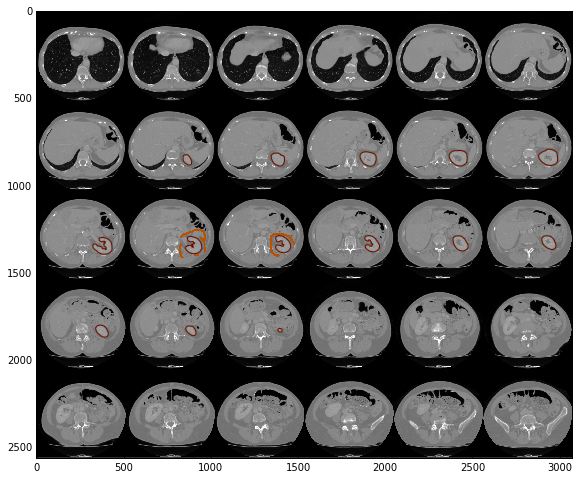

In [10]:
data3d, true_segmentation, seeds, voxelsize_mm = prepare_data(1, "left_kidney")
plt.figure(figsize=(10,8))
sed3.show_slices(data3d, seeds=seeds, contour=true_segmentation, shape=[5, 6])

In [11]:

datap["processing_information"]["organ_segmentation"].keys()

dict_keys(['processing_time', 'time_start', 'oseg_input_params', 'organ_interactivity_counter', 'seeds'])

# Data screenshots

Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
C:\Users\miros\Miniconda3\envs\lisa36\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
C:\Users\miros\Miniconda3\envs\lisa36\lib\site-packages\numpy\ma\core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(-0.5, 1535.5, 1535.5, -0.5)

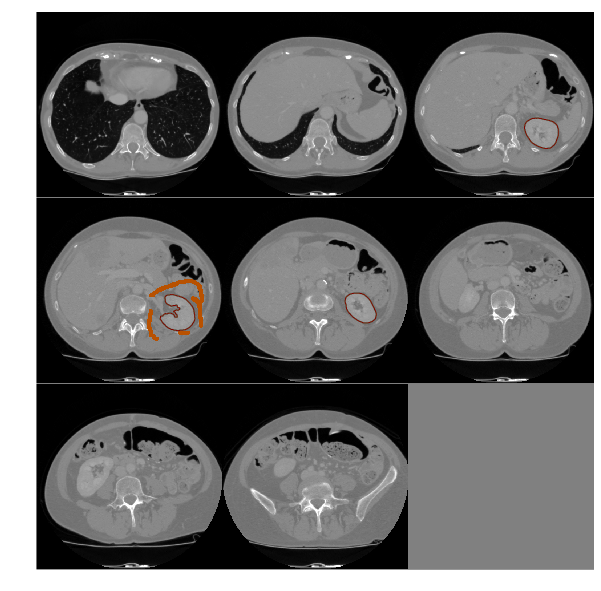

In [12]:

img, seg, seeds, voxelsize_mm = prepare_data(1, "left_kidney")
plt.figure(figsize=(10,15))
import copy
imgview = copy.copy(img)
imgview[:,:,-1] = 0
imgview[:,-1,:] = 0
imgview[-1,:,:] = 0
sed3.show_slices(imgview, contour=seg, seeds=seeds, show=False, slice_step=16.9, first_slice_offset_to_see_seed_with_label=2)
plt.axis("off")
# plt.savefig("../graphics/msgc-ct-imgsample_separated.png")

In [13]:
np.unique(seeds)

array([0, 1, 2], dtype=uint8)

### LaTeX export functions

In [14]:
def to_latex_file(df, fn):
    with open(fn, "w") as f:
        f.write(df.to_latex())
        
def latex_float(f, precision=4):
    float_str = "{0:." + str(int(precision)) + "g}"
    float_str = float_str.format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def float_to_latex_file(fl, fn, precision=4):
    string = latex_float(fl, precision=precision)
    with open(fn, "w") as f:
        f.write(string)

def num2latex(num, filename=None, precision=4):
    if type(num) is str:
        float_str = num
    else:
        float_str = "{0:." + str(int(precision)) + "g}"
        float_str = float_str.format(num)
        
    if float_str[:4] == r"\num":
        pass
    else:
        float_str = "\\num{" + float_str + "}" 
    if filename is not None:
        with open(filename, "w") as f:
            f.write(float_str)
    return float_str

def to_file(text, fn):
    with open(fn, "w") as f:
        f.write(text)

## CT data, opakovaný experiment

In [15]:
def process_gc_stats(stats1, prefix=None):
    if prefix is None:
        prefix = ""
    
        
    outstats = {}
    for key in stats1:
        outstats[prefix + key] = stats1[key]
        
    outstats[prefix + "nlinks number"] = np.sum(np.asarray(outstats[prefix + "nlinks shape"]), axis=0)[0]
    outstats[prefix + "tlinks number"] = np.sum(np.asarray(outstats[prefix + "tlinks shape"]), axis=0)[0]
    outstats.pop(prefix + "tlinks shape")
    outstats.pop(prefix + "nlinks shape")
    outstats[prefix + "edge number"] = outstats[prefix + "nlinks number"] + outstats[prefix + "tlinks number"]

    return outstats

    
def merge_stats(stats0, stats1, stats2, labels=None):
    if labels is None:
        labels = [""] * 3
    
   
    stats0 = process_gc_stats(stats0, labels[0])
    stats1 = process_gc_stats(stats1, labels[1])
    stats2 = process_gc_stats(stats2, labels[2])
    stats = {}
    stats.update(stats0)
    stats.update(stats1)
    stats.update(stats2)

    
    return stats

def run_gc_with_defined_setup(img, segparams, seeds, dry_run=False):
    
    start = time.time()
    gc = pycut.ImageGraphCut(img, segparams=segparams)
    gc.set_seeds(seeds)
    if dry_run:
        thr = np.mean([np.min(img), np.max(img)])
        sg1 = (img < thr).astype(np.uint8)
        stats1 = {"nlinks shape": [[5, 5]], "tlinks shape": [[5, 5]]}
    else:
        gc.run()
        sg1 = gc.segmentation
        stats1 = gc.stats
    elapsed1 = (time.time() - start)
    err1 = np.sum(np.abs(seg - (1 - sg1)))
    stats1["time"] = elapsed1
    stats1["error"] = err1
    return stats1


def add_data_and_algoritm_info(stats, data_params_dict, segparams, start, true_segmentation, voxelsize_mm):
    #     stats['msgc time'] = elapsed1
#     stats['normal time'] = elapsed2
#     stats['data id'] = data_params[0]
#     stats['data offset'] = data_params[1]
#     stats['target organ'] = data_params[1]
#     stats['data radius'] = data_params[2]
#     stats['data size'] = data_params[0]
    stats.update(data_params_dict)
    stats["data size 0"] = true_segmentation.shape[0]
    stats["data size 1"] = true_segmentation.shape[1]
    stats["data size 2"] = true_segmentation.shape[2]
    stats["data size px"] = np.prod(true_segmentation.shape)
    stats["data target size px"] = np.sum(true_segmentation > 0)
    stats["data voxesize mm^3"] = np.prod(voxelsize_mm)
    stats["data voxesize mm 0"] = voxelsize_mm[0]
    stats["data voxesize mm 1"] = voxelsize_mm[1]
    stats["data voxesize mm 2"] = voxelsize_mm[2]
    stats["block size"] = segparams["block_size"]
#     stats["data seedsz"] = data_params[3]
#     stats["GC error"] = err2
#     stats["MSGC error"] = err1
    stats['machine hostname'] = machine_hostname
    stats['experiment iteration start time'] = start
    
    return stats

def add_data_seaborn(stats, data_params_dict, segparams, start, i, label, true_segmentation, voxelsize_mm):
    stats = process_gc_stats(stats, "")
    stats = add_data_and_algoritm_info(stats, data_params_dict, segparams, start, true_segmentation, voxelsize_mm)
    stats["method"] = label
    dfinew = pd.DataFrame(stats, index=[i*3 + 0])
    #dfnew = dfnew.append(dfinew, sort=True)
    
    return dfinew

In [16]:
#for par in it:
#    print par
i = 0

In [17]:
if op.exists(fname) and not force_rewrite:
    df = pd.read_csv(fname)#, index_col=0)
else:
    df = pd.DataFrame([])
    
if op.exists(fnamenew) and not force_rewrite:
    dfnew = pd.read_csv(fnamenew)#, index_col=0)
else:
    dfnew = pd.DataFrame([])


i = 0
np.random.seed(rnd_seed)

import platform
machine_hostname = platform.node()

it = itertools.product(dp_ircad_id, dp_keys)
for data_params in it:
# dp_ircad_id = [1, 10, 11]
# dp_keys = ["left_kidney"]

    start = time.time()
    img, seg, seeds, voxelsize_mm = prepare_data(data_params[0], data_params[1])
    stats0 = run_gc_with_defined_setup(img, segparams0, seeds, dry_run=dry_run)
    stats1 = run_gc_with_defined_setup(img, segparams1, seeds, dry_run=dry_run)
    stats2 = run_gc_with_defined_setup(img, segparams2, seeds, dry_run=dry_run)

    
    data_params_dict = dict(zip(["data id", "data organ key"], data_params))
#     stats = merge_stats(stats0, stats1, stats2, labels)
#     stats = add_data_and_algoritm_info(stats, data_params_dict, segparams0, start, seg, voxelsize_mm)
    
#     dfi = pd.DataFrame(stats, index=[i])
    
#     # display(df)
#     df = df.append(dfi, sort=True)
#     df.to_csv(fname, index=False)
    
    dfinew = add_data_seaborn(stats0, data_params_dict, segparams0, start, i, labels[0], seg, voxelsize_mm)
    dfnew = dfnew.append(dfinew, sort=True)
    dfinew = add_data_seaborn(stats1, data_params_dict, segparams1, start, i, labels[1], seg, voxelsize_mm)
    dfnew = dfnew.append(dfinew, sort=True)
    dfinew = add_data_seaborn(stats2, data_params_dict, segparams2, start, i, labels[2], seg, voxelsize_mm)
    dfnew = dfnew.append(dfinew, sort=True)
    
    dfnew.to_csv(fnamenew, index=False)
    
    i += 1
    

#     plt.figure(figsize=[10,15])
#     sed3.show_slices(img, contour=sg1, seeds=seeds, slice_step=10)
#     plt.figure(figsize=[10,15])
#     sed3.show_slices(img, contour=sg2, seeds=seeds, slice_step=10)

Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.
Unable to read dicom file dicomdir.pkl
File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.


In [18]:
# export all to latex
dtt.save(dfnew, "raw_table")

# Data processing graphs, statistics

In [25]:
df = pd.read_csv(fnamenew)
df.rename(columns={"msgc time": "MSGC time"})
# dfs = df[(df["data seedsz"]==3) & (df["data offset"] == 3) & (df["data radius"] == 10)]
# dfs_plus = dfs[dfs['data size'] > 160]
dfs = df

import seaborn as sns
sns.set_context("paper")
sns.set_style("white")

In [26]:
dfs.keys()

Index(['block size', 'data id', 'data organ key', 'data size 0', 'data size 1',
       'data size 2', 'data size px', 'data target size px',
       'data voxesize mm 0', 'data voxesize mm 1', 'data voxesize mm 2',
       'data voxesize mm^3', 'edge number', 'error',
       'experiment iteration start time', 'machine hostname', 'method',
       'nlinks number', 'time', 'tlinks number'],
      dtype='object')

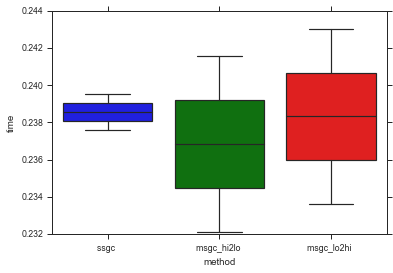

In [27]:
sns.boxplot(data=df, y="time", x="method")

C:\Users\miros\Miniconda3\envs\lisa36\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


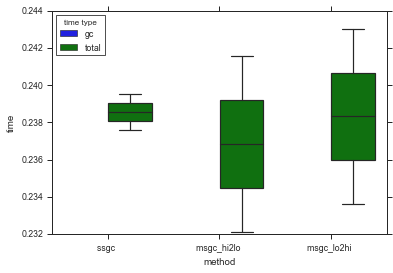

In [29]:
uu = pd.melt(df.rename(columns={"gc time": "gc", "time": "total"}), value_vars=["gc", "total"], id_vars=["method"], var_name="time type", value_name="time")
sns.boxplot(data=uu, hue="time type",y="time", x="method")
plt.savefig(op.join(latex_dir, "msgc_time_boxplot_ct.pdf"), dpi=1000)